In [30]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations

from gensim.utils import simple_preprocess

from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_json('data/yle-articles.json', orient='records')

In [4]:
df.head()

,id,date,title,body,subjects
0,3-6475540,2013-01-31T22:53:33+0200,UMK-finalistit valittu – Great Wide North maks...,Great Wide North sai toisessa semifinaalissa ...,"[kulttuuri, musiikki, viihde, uuden musiikin k..."
1,3-6475536,2013-01-31T22:53:15+0200,YK:n pääsihteeri: Tieto Israelin iskusta Syyri...,Ban Ki-moon kehottaa Lähi-idän kaikki valtioi...,"[ulkomaat, yhdistyneiden kansakuntien pääsihte..."
2,3-6475539,2013-01-31T22:53:04+0200,AIK kuritti Rögleä - Pirnes kahmi tehopisteitä,Esa Pirnes oli tehokkaalla pelipäällä Elitser...,"[urheilu, jääkiekko, aik if, svenska hockeylig..."
3,20-162900,2013-01-31T22:43:34+0200,Polkupyörällä Islannissa: kirja lähtee painoon,"On taas se aika vuodesta, kun olo on melko ep...","[matkakertomukset, matkakirjallisuus (kaunokir..."
4,3-6475529,2013-01-31T22:38:24+0200,TPS:n oljenkorsi ei katkennut - 36 pistettä yh...,TPS säilytti SaiPasta otetun 3-1-voiton ansio...,"[urheilu, jääkiekon miesten sm-liiga, jääkiekk..."


In [11]:
df['title'] = df['title'].astype(str)
df['body'] = df['body'].astype(str)

In [13]:
df['body'] = df['title'] + ' ' + df['body']

In [14]:
%%time
tokenized = df['body'].apply(simple_preprocess)

In [33]:
doc_lengths = tokenized.apply(lambda x: len(x))

print("length of list:",len(doc_lengths),
      "\naverage document length", doc_lengths.mean(),
      "\nminimum document length", doc_lengths.min(),
      "\nmaximum document length", doc_lengths.max(),
      "\nnumber document less than {} words:".format(20), (doc_lengths < 20).sum(),
      "\nnumber document more than {} words:".format(1000), (doc_lengths > 1000).sum())

length of list: 702673 
average document length 199.91770567532836 
minimum document length 0 
maximum document length 20333 
number document less than 20 words: 7147 
number document more than 1000 words: 5147


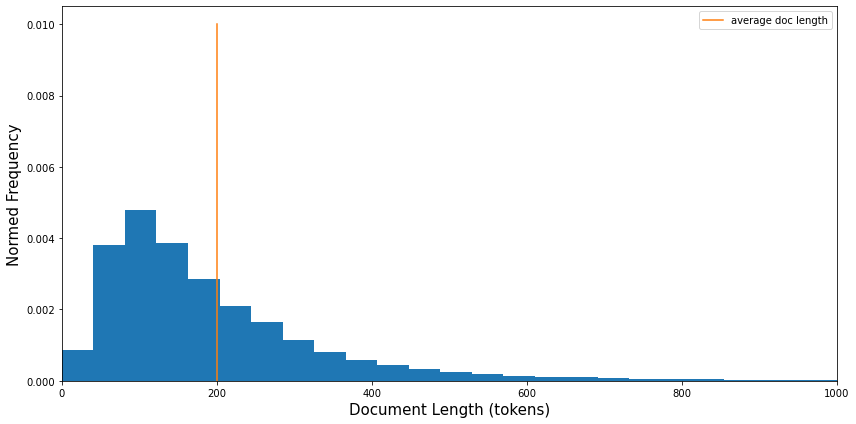

In [44]:
# plot a histogram of document length
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, bins=500, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()

plt.xlim(0, 1000)
# plt.ylim(0, 1)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0, 0.01, 10)], np.linspace(0.0, 0.01, 10), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [45]:
df['doc_len'] = doc_lengths
df['tokens'] = tokenized

In [49]:
# filter out documents < 20 or > 1000 tokens
df_filtered = df[(df['doc_len'] > 20) & (df['doc_len'] < 1000)]

In [50]:
df_filtered.shape

(689875, 7)

In [48]:
df.shape

(702673, 7)

In [51]:
df_filtered.head()

,id,date,title,body,subjects,doc_len,tokens
0,3-6475540,2013-01-31T22:53:33+0200,UMK-finalistit valittu – Great Wide North maks...,UMK-finalistit valittu – Great Wide North maks...,"[kulttuuri, musiikki, viihde, uuden musiikin k...",110,"[umk, finalistit, valittu, great, wide, north,..."
1,3-6475536,2013-01-31T22:53:15+0200,YK:n pääsihteeri: Tieto Israelin iskusta Syyri...,YK:n pääsihteeri: Tieto Israelin iskusta Syyri...,"[ulkomaat, yhdistyneiden kansakuntien pääsihte...",109,"[yk, pääsihteeri, tieto, israelin, iskusta, sy..."
2,3-6475539,2013-01-31T22:53:04+0200,AIK kuritti Rögleä - Pirnes kahmi tehopisteitä,AIK kuritti Rögleä - Pirnes kahmi tehopisteitä...,"[urheilu, jääkiekko, aik if, svenska hockeylig...",107,"[aik, kuritti, rögleä, pirnes, kahmi, tehopist..."
3,20-162900,2013-01-31T22:43:34+0200,Polkupyörällä Islannissa: kirja lähtee painoon,Polkupyörällä Islannissa: kirja lähtee painoon...,"[matkakertomukset, matkakirjallisuus (kaunokir...",227,"[polkupyörällä, islannissa, kirja, lähtee, pai..."
4,3-6475529,2013-01-31T22:38:24+0200,TPS:n oljenkorsi ei katkennut - 36 pistettä yh...,TPS:n oljenkorsi ei katkennut - 36 pistettä yh...,"[urheilu, jääkiekon miesten sm-liiga, jääkiekk...",209,"[tps, oljenkorsi, ei, katkennut, pistettä, yhä..."


In [63]:
df_filtered.iloc[0]['title']

'UMK-finalistit valittu – Great Wide North maksimipisteillä jatkoon'

In [52]:
df_filtered.to_pickle('data/dev/yle-articles-tokens.pkl')

In [54]:
df_filtered.reset_index(inplace=True, drop=True)

In [55]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_filtered['tokens'])]

In [56]:
model = Doc2Vec(vector_size=128, min_count=2, workers=4, dbow_words=1, negative=5)

In [57]:
%%time
model.build_vocab(documents)

CPU times: user 5min 52s, sys: 3.2 s, total: 5min 55s
Wall time: 5min 56s


In [ ]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=30)

In [ ]:
model.save('models/doc2vec_full')

In [60]:
# now we will validate if the model able to find the document itself is the most similar one
doc_id = 2

In [61]:
inferred_vector = model.infer_vector(documents[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

In [62]:

print('Document ({}): «{}»\n'.format(doc_id, ' '.join(documents[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(documents[sims[index][0]].words)))

Document (2): «aik kuritti rögleä pirnes kahmi tehopisteitä esa pirnes oli tehokkaalla pelipäällä elitserienissä myös ville lajunen heilutti maaliverkkoa aik antoi kovaa kyytiä röglelle ruotsin jääkiekon elitserienissä aik ykkösketjussa hyökännyt esa pirnes merkkautti neljä tehopistettä kun rökitti vieraansa peräti aik osui kahdessa ensimmäisessä erässä kummassakin kahdesti ja pirnes sai syöttömerkinnät ja osumiin päätöserässä pirnes pääsi iskemään taululle jo lukemat röglen kavennusmaalin teki mathias tjärnqvist kymmenen minuuttian ennen loppusummeria juhamatti aaltonen sai syöttöpisteen osumaan aaltonen on ollut viime aikoina kovassa vedossa sillä hän on tehnyt neljässä viime ottelussa tehot kierroksen kolmas suomalainen pistemies oli färjestadin takalinjoilla häärivä ville lajunen hän pääsi maalin makuun joukkueensa kaataessa brynäsin vieraskentällä aik tavoin maalein»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d128,n5,w5,mc2,s0.001,t4):

MOST (2, 0.9206591844558716): «aik kuri

In [26]:
model.wv.most_similar('tehokkaalla')

[('vaisulla', 0.6381917595863342),
 ('vahvalla', 0.629941463470459),
 ('pienelläkin', 0.627147912979126),
 ('taitavalla', 0.6257155537605286),
 ('taidokkaalla', 0.6211278438568115),
 ('onnistuneella', 0.6185193657875061),
 ('joustavalla', 0.6067602634429932),
 ('mainiolla', 0.6042071580886841),
 ('laadukkaalla', 0.603455126285553),
 ('viileällä', 0.6015875935554504)]

In [27]:
model.wv['tehokkaalla'].shape

(128,)

In [64]:
model.wv.vocab

KeyError: 0